# Reading 1D ecRad Output File. Effective Radius $r_e$ variation.

Version 6: 2023-07-17

Fixed parameters:

1. Radiative Transfer Model: ecRad
2. Cosine of solar zenith angle: $\mu = 0.6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006).
3. SW albedo: $\alpha = 0.05$ (Hartmann & Berry, 2017).
4. LW emissivity: $\epsilon = 0.97$ (REFERENCE?).
5. Skin temperature as surface temperature: $T_{skin} = 300 K$ (290 to 300 K (Jin & Dickinson, 2010)).
6. No gases and aerosols.
7. No liquid water.
8. Tropical Sounding Climatology (Temperature, Pressure and Specific Humidity) (Lapse Rate of $6.7\;K/km$ (see "1D_ecrad_input_creator_height_v6.ipynb")).

Variable parameters:
1. Macro: Temperature (Altitude-position) = 236 K, 218 K and 201 K for cloud middle level.
2. Macro: Geometrical Depth $\Delta h = 1.5 km$.
3. Macro: Ice Water Path (IWP) = 30 $g/m^2$ (Sokol & Hartmann 2020):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/km)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = IWP{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$

4. Micro: Effective Radius $r_e$ = 1 to 100 $\mu m$ every 5 (1, 5, 10, 15...) (REFERENCE?).
5. Ice Optical Schemes:

    5.1 Fu 1996 and Fu, Yang & Sun 1998 (1O).
    
    5.2 Yi et al. 2013 (2O).
    
    5.3 Baran et al. 2016 (3O).
    
    5.4 Baran et al. 2014 (4O).
    
    
6. Solvers: Tripleclouds

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
4. matplotlib : 3.6.2

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib notebook

## Reading data

### ecRad output data

- 1O: Fu (Fu 1996 / Fu, Yang & Sun 1998)
- 2O: Yi (Yi et al. 2013)
- 3O: Baran2016 (Baran et al. 2016)
- 4O: Baran (Baran et al. 2014)

In [2]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
for pert in ['236','218','201']:
    for opt in range(1,5):
        file = 'output_1D_matrix_re_'+pert+'_'+str(opt)+'O1S_v6.nc'
        globals()['ecrad_out_'+pert+'_'+str(opt)+'O1S'] = xr.open_dataset(data_path+file)

### Tropical Profile

In [3]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_9037/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [4]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_out_236_1O1S.pressure_hl.values)

height_normal  = tropical_profile['height (km)'].iloc[::-1]
height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(ecrad_out_236_1O1S.pressure_hl.values)

In [5]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

height_hl_pd    = pd.Series(height_hl[0])

### Cloud-radiative Heating (CRH) Rate matrix calculation:

Cloud-radiative Heating (CRH) rate in $K\;d^{-1}$ for each spectral component $i$ (SW and LW):

$$CRH_{i} \;=\; - \frac{g_0}{C_P}\frac{\partial }{\partial P}(CRE_{i})\;\;\frac{K}{s}\times\;86400\;\frac{s}{d}$$

where $g_0$ is the standard gravity acceleration ($9.8\;ms^{-2}$), $C_P$ is the specific heat capacity of dry air ($1080\;J kg^{-1} K^{-1}$) and $CRE_{i}$ is the Cloud Radiative Effect for each spectral component $i$ (SW and LW), computed as:

$$CRE_{i} \;=\; F_{All_{i}}^{NET} - F_{Clear_{i}}^{NET}$$

where $F^{NET}$ is the NET irradiance or flux ($Wm^{-2}$), computed as:

$$F_{i}^{NET} \;=\; F_{i}^{Downward} - F_{i}^{Upward}$$

The sign in the CRH equation is because of the definition of the outgoing fluxes as positive ??

In [6]:
rows_re = ecrad_out_236_1O1S.sizes['column']     # Effective Radius (1, 5 - 100 um)
prof    = ecrad_out_236_1O1S.sizes['half_level'] # Vertical Profile

## Heat capacity [J kg^-1 K^-1]:
cp = 1.08*10**(3)
## Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
## Gravity [m s^-2]:
g = 9.8

for pert in ['236','218','201']:
    ## Heating rates matrices [K day-1]:
    globals()['H_lw_'+pert] = np.zeros((4, rows_re, prof))
    globals()['H_sw_'+pert] = np.zeros((4, rows_re, prof))
    globals()['H_'+pert]    = np.zeros((4, rows_re, prof))

    ## Matrices for plotting:
    globals()['H_sw_'+pert+'_plot'] = np.zeros((4, prof, rows_re))
    globals()['H_lw_'+pert+'_plot'] = np.zeros((4, prof, rows_re))
    globals()['H_'+pert+'_plot']    = np.zeros((4, prof, rows_re))

    for opt in range(1,5): # per optical scheme
        ecrad_out = eval('ecrad_out_'+pert+'_'+str(opt)+'O1S')
        for i in range(rows_re):
            pres = ecrad_out.pressure_hl.values[i] # Pressure [Pa]

            # Net Fluxes [W m-2]
            lw_net_flux_cloudy = ecrad_out.flux_dn_lw.values[i] - ecrad_out.flux_up_lw.values[i]
            lw_net_flux_clear  = ecrad_out.flux_dn_lw_clear.values[i] - ecrad_out.flux_up_lw_clear.values[i]
            sw_net_flux_cloudy = ecrad_out.flux_dn_sw.values[i] - ecrad_out.flux_up_sw.values[i]
            sw_net_flux_clear  = ecrad_out.flux_dn_sw_clear.values[i] - ecrad_out.flux_up_sw_clear.values[i]

            # Cloud Radiative Effect [W m-2]
            lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
            sw_cre = sw_net_flux_cloudy - sw_net_flux_clear
            
            # The sign is because of the definition of Outgoing fluxes as positive:
            # By using the diff function:
            #H_lw[opt-1,i,:] = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day^(-1)
            #H_sw[opt-1,i,:] = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day^(-1)
            # By using the gradient function:
            eval('H_lw_'+pert)[opt-1,i,:] = -(g/cp)*(np.gradient(lw_cre, pres))*86400 # K day^(-1)
            eval('H_sw_'+pert)[opt-1,i,:] = -(g/cp)*(np.gradient(sw_cre, pres))*86400 # K day^(-1)

        eval('H_'+pert)[opt-1,:,:] = eval('H_lw_'+pert)[opt-1,:,:] + eval('H_sw_'+pert)[opt-1,:,:]

        # For plotting:
        eval('H_sw_'+pert+'_plot')[opt-1,:,:] = np.transpose(eval('H_sw_'+pert)[opt-1,:,:])
        eval('H_lw_'+pert+'_plot')[opt-1,:,:] = np.transpose(eval('H_lw_'+pert)[opt-1,:,:])
        eval('H_'+pert+'_plot')[opt-1,:,:]    = np.transpose(eval('H_'+pert)[opt-1,:,:])

#### Cloud Heating Rate (CRH) matrix for plotting (3 perturbations together):

In [7]:
## New Matrices for plotting:
H_sw_plot = np.zeros((4, prof, rows_re))
H_lw_plot = np.zeros((4, prof, rows_re))
H_plot    = np.zeros((4, prof, rows_re))

for pert in [236, 218, 201]:
    pert_i = (temp.iloc[tropopause_i:] - pert).abs().argmin() # iloc position
    i = tropopause_i + pert_i
#    if pert == 218: bottom_step = 5
#    else: bottom_step = 4
#     if pert == 236: top_step = 3
#     else: top_step = 4
    H_sw_plot[:,i-4:i+5,:] = eval('H_sw_'+str(pert)+'_plot')[:,i-4:i+5,:]
    H_lw_plot[:,i-4:i+5,:] = eval('H_lw_'+str(pert)+'_plot')[:,i-4:i+5,:]
    H_plot[:,i-4:i+5,:] = eval('H_'+str(pert)+'_plot')[:,i-4:i+5,:]

WARNING: The three level cloud matrix visualization is taking out the bottom point in the Middle cloud level.


 ### CRH vs $R_e$ for top and bottom layer

In [8]:
re   = np.arange(5,105,5)
re   = np.insert(re, 0, 1)
rows = len(re)

In [9]:
perti = (temp.iloc[tropopause_i:] - 218).abs().argmin()
perti_height = height_hl_pd.iloc[tropopause_i+perti]
bottom_hi    = height_hl_pd.index.get_loc(height_hl_pd[height_hl_pd == (perti_height - 1.25)].index[0])
top_hi       = height_hl_pd.index.get_loc(height_hl_pd[height_hl_pd == (perti_height + .75)].index[0])
print(height_hl_pd[top_hi:bottom_hi])
print(H_sw_plot[0, top_hi:bottom_hi, np.where(re == 30)[0]])
print(H_lw_plot[0, top_hi:bottom_hi, np.where(re == 30)[0]])

26    13.625
27    13.375
28    13.125
29    12.875
30    12.625
31    12.375
32    12.125
33    11.875
dtype: float64
[[4.61430024 8.49509807 7.25191672 6.21218804 5.3182762  4.58866709
  3.96365144 1.75660694]]
[[-4.96281073 -6.93649695 -1.7014429   3.1302471   8.36932459 14.53867106
  23.06087576 14.96518734]]


<IPython.core.display.Javascript object>


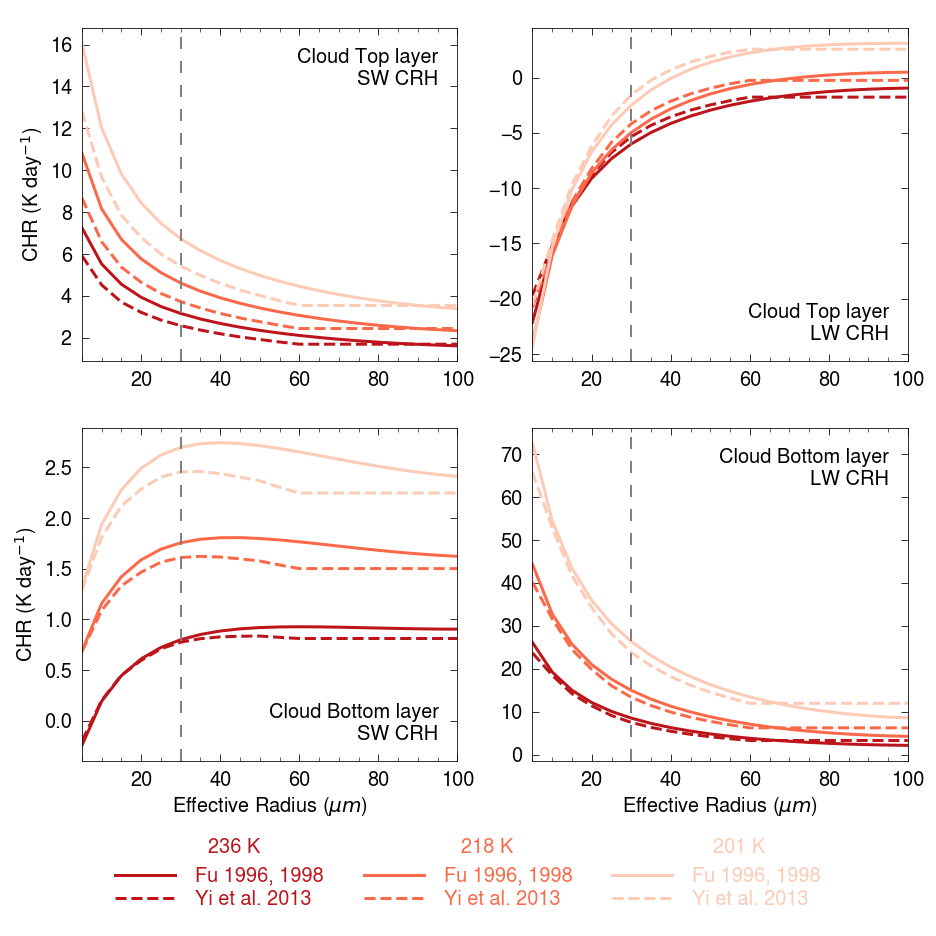

In [10]:
fontname = 'Nimbus Sans' # Arial
fontsize = 20
flength  = 13 # inches
fheigth  = flength*1 # inches

# my_colors = [(88/255, 148/255, 197/255), (169/255, 23/255, 38/255),
#              (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
#              (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
#              (107/255, 188/255, 233/255), 'grey']

rows    = 2
columns = 2
f, ax = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi=72)
plt.subplots_adjust(top = 0.97, bottom = 0.1875, left = 0.0875, right = 0.97, 
                    hspace = .2, wspace = .2)

# STRUCTURE:
# Frame 1x1: SW - Top layer
# Frame 1x2: LW - Top Layer
# Frame 2x1: SW - Bottom Layer
# Frame 2x2: LW - Bottom Layer
# Color per temperature. Linestyle per Scheme.

OptSch   = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
linestye = ['solid', 'dashed', 'dotted', 'dashdot']
handles  = []
labels   = []
for pert in [236, 218, 201]:
    perti        = (temp.iloc[tropopause_i:] - pert).abs().argmin() # iloc position
    perti_height = height_hl_pd.iloc[tropopause_i+perti] # middle point of cloud in terms of height
    # iloc positions of bottom and top layers:
    if pert == 218: lower_range = 1; upper_range = .75; # REPAIR THREE LEVEL MATRIX
    else: lower_range = .75; upper_range = 1
    bottom_hi    = height_hl_pd.index.get_loc(height_hl_pd[height_hl_pd == (perti_height - lower_range)].index[0])
    top_hi       = height_hl_pd.index.get_loc(height_hl_pd[height_hl_pd == (perti_height + upper_range)].index[0])
    for opt in range(2):
        color = matplotlib.cm.Reds(.8 - [236,218,201].index(pert)*.3)
        if opt == 0: first_point = 1
        else: first_point = 0
        # SW, Top Layer:
        h1a = ax[0,0].plot(re[first_point:], H_sw_plot[opt, top_hi, first_point:],
                         linestyle = linestye[opt], 
                         linewidth = 3, color = color)
        h1b = ax[0,0].axvline(x = 30, linestyle = 'dashed', color = 'grey',
                              dashes = (6, 6), linewidth = 2)
        handles = handles + h1a
        labels.append(OptSch[opt])
        #labels.append(str(pert) + ' K - ' + OptSch[opt])

        # LW, Top Layer:
        h2a = ax[0,1].plot(re[first_point:], H_lw_plot[opt, top_hi, first_point:],
                           linestyle = linestye[opt], 
                           linewidth = 3, color = color)
        h2b = ax[0,1].axvline(x = 30, linestyle = 'dashed', color = 'grey',
                             dashes = (6, 6), linewidth = 2)
        # SW, Bottom Layer:
        h3a = ax[1,0].plot(re[first_point:], H_sw_plot[opt, bottom_hi, first_point:],
                          linestyle = linestye[opt], 
                          linewidth = 3, color = color)
        h3b = ax[1,0].axvline(x = 30, linestyle = 'dashed', color = 'grey',
                             dashes = (6, 6), linewidth = 2)
        # LW, Bottom Layer:
        h4a = ax[1,1].plot(re[first_point:], H_lw_plot[opt, bottom_hi, first_point:],
                          linestyle = linestye[opt], 
                          linewidth = 3, color = color)
        h4b = ax[1,1].axvline(x = 30, linestyle = 'dashed', color = 'grey',
                             dashes = (6, 6), linewidth = 2)
    
    f.text(0.25 + (0.27*[236,218,201].index(pert)), 0.095, str(pert) + ' K',
           ha = 'center', va = 'center', fontname = fontname, fontsize = fontsize,
           color = color)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

# AXIS PARAMETERS
#X Axis
ax[1,0].set_xlabel(r'Effective Radius ($\mu m$)', fontname = fontname, 
                   fontsize = fontsize, color = 'black', labelpad = 5)
ax[1,1].set_xlabel(r'Effective Radius ($\mu m$)', fontname = fontname, 
                   fontsize = fontsize, color = 'black', labelpad = 5)
for i in range(2):
    for j in range(2):
        #ax[i, j].set_xscale('log')
        major_ticks_x = np.arange(-20, 120, 20)
        minor_ticks_x = np.arange(-20, 120, 5)
        ax[i,j].set_xticks(major_ticks_x)
        ax[i,j].set_xticks(minor_ticks_x, minor=True)
        ax[i,j].set_xlim(5, 100)
        ax[i,j].tick_params(axis = 'x', which = 'major', color = 'black',
                            size = 7, direction = 'in', top = True,
                            labelsize = fontsize, pad = 10)
        ax[i,j].tick_params(axis = 'x', which = 'minor',
                            color = 'black', size = 4,
                            direction = 'in', top = True)
        for tick in ax[i,j].get_xticklabels():
            tick.set_fontname(fontname)
    
#Y Axis
ax[0,0].set_ylabel('CHR (K day$^{-1}$)', fontname = fontname, fontsize = fontsize,
                   color = 'black', labelpad = 5)
ax[1,0].set_ylabel('CHR (K day$^{-1}$)', fontname = fontname, fontsize = fontsize,
                   color = 'black', labelpad = 5)

for i in range(2):
    for j in range(2):
        #major_ticks_y = np.arange(-60, 1100, 10)
        #minor_ticks_y = np.arange(-60, 60, 5)
        #ax.set_xticks(major_ticks_y)
        #ax.set_xticks(minor_ticks_y, minor=True)
        #ax.set_xlim(-50, 50)
        ax[i,j].tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
        ax[i,j].tick_params(axis = 'y', which = 'minor', color = 'black',
               size = 4, direction = 'in', right = True)
        for tick in ax[i,j].get_yticklabels():
            tick.set_fontname(fontname)

# Additional Texts:
ax[0,0].text(0.95, 0.94, 'Cloud Top layer'+'\n'+'SW CRH',
             ha = 'right', va = 'top', transform = ax[0, 0].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')
ax[0,1].text(0.95, 0.05, 'Cloud Top layer'+'\n'+'LW CRH',
             ha = 'right', va = 'bottom', transform = ax[0, 1].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')
ax[1,0].text(0.95, 0.05, 'Cloud Bottom layer'+'\n'+'SW CRH',
             ha = 'right', va = 'bottom', transform = ax[1, 0].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')
ax[1,1].text(0.95, 0.94, 'Cloud Bottom layer'+'\n'+'LW CRH',
             ha = 'right', va = 'top', transform = ax[1, 1].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')


# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'lower center',
                     bbox_to_anchor = (.5, .01),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 3, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 3, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_crh_re_1S_v6.png', dpi=500)

Checking cloud layer selection

<IPython.core.display.Javascript object>


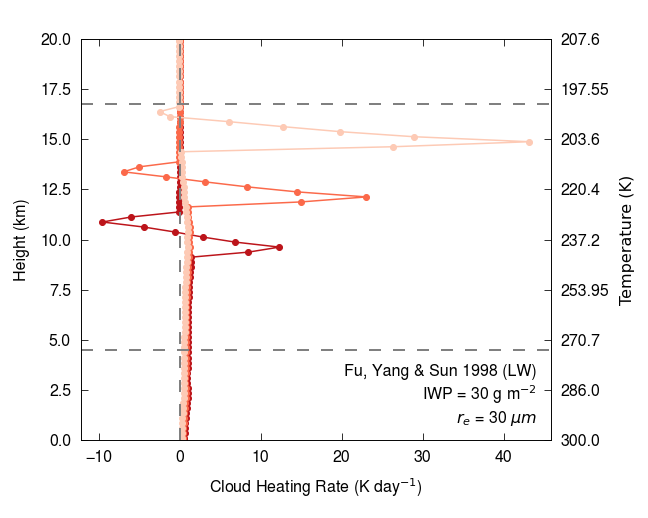

In [11]:
fontname  = 'Nimbus Sans'
fontsize  = 16
my_colors = [(88/255, 148/255, 197/255), (229/255, 179/255, 69/255),
             (169/255, 23/255, 38/255), (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
             (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
             (107/255, 188/255, 233/255), 'grey']
flength    = 9 # inches
fheigth    = flength*.8 # inches
f, ax      = plt.subplots(figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left = 0.125, right = 0.85)

for pert in [236, 218, 201]:
    color = matplotlib.cm.Reds(.8 - [236,218,201].index(pert)*.3)
    h1 = ax.plot(eval('H_lw_'+str(pert)+'_plot')[0,:,np.where(re == 30)[0]][0],  height_hl_pd, '.-', markersize = 12,
                 color = color, alpha = 1)
melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h2 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h3 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
h4 = ax.axvline(x = 0, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

# X Axis:
ax.set_xlabel(r'Cloud Heating Rate (K day$^{-1}$)', fontname = fontname, fontsize = fontsize,
              color = 'black',labelpad = 10)
#major_ticks_x = np.arange(-60,60,3)
#minor_ticks_x = np.arange(-60,60,1)
#ax.set_xticks(major_ticks_x)
#ax.set_xticks(minor_ticks_x, minor=True)
#ax.set_xlim(-15,15)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
#ax.tick_params(axis = 'x', which = 'minor',
#               color = 'black', size = 4,
#               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
    
# Y Axis:
ax.set_ylabel('Height (km)', fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
#major_ticks_y = np.arange(-60,60,3)
#minor_ticks_y = np.arange(-60,60,1)
#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0,20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)', fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.97, 0.03, 'Fu, Yang & Sun 1998 (LW)'+
        '\n'+r'IWP = 30 g m$^{-2}$'+
        '\n'+r'$r_{e}$ = 30 $\mu m$',
        ha = 'right', va = 'bottom', transform = ax.transAxes,
        fontname = fontname, fontsize = fontsize, color = 'black')
        
# Legend:
#handles = h1 + h2 + h3
#labels  = ['SW CRH','LW CRH','CHR']    
#legend  = plt.legend(handles, labels, loc = 'upper right',#bbox_to_anchor=(.675, 1.075),#
#                     ncol = 1, handlelength = 1.5, handletextpad = 1,
#                     labelspacing = .1, columnspacing = 2, numpoints = 1,
#                     frameon = False, prop = {'size':fontsize})

# Additional Texts:
# ax.set_title('BOD Degradation over time',
#              fontsize=fontsize,
#              fontweight='bold',
#              color='black')
#ax.text(0.95, 0.05, r'1O1S 0.2 $g/kg^{-1}$'+'\n'+'10 K depth',
#        ha = 'right', va = 'bottom', transform = ax.transAxes,
#        fontsize = fontsize, color = 'black')

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_1O1S0A_236_v6.png', dpi = 500)

### Evaluating maximum values of CRH

In [12]:
print('LW Fu max: ',H_lw_plot[0,:,1:].max())
print('LW Fu min: ',H_lw_plot[0,:,1:].min())
print('LW Yi max: ',H_lw_plot[1,:,1:].max())
print('LW Yi min: ',H_lw_plot[1,:,1:].min())
print('LW Baran2016 max: ',H_lw_plot[2,:,1:].max())
print('LW Baran2016 min: ',H_lw_plot[2,:,1:].min())
print('LW Baran2014 max: ',H_lw_plot[3,:,1:].max())
print('LW Baran2014 min: ',H_lw_plot[3,:,1:].min())
print('')
print('SW Fu max: ',H_sw_plot[0,:,1:].max())
print('SW Fu min: ',H_sw_plot[0,:,1:].min())
print('SW Yi max: ',H_sw_plot[1,:,1:].max())
print('SW Yi min: ',H_sw_plot[1,:,1:].min())
print('SW Baran2016 max: ',H_sw_plot[2,:,1:].max())
print('SW Baran2016 min: ',H_sw_plot[2,:,1:].min())
print('SW Baran2014 max: ',H_sw_plot[3,:,1:].max())
print('SW Baran2014 min: ',H_sw_plot[3,:,1:].min())
print('')
print('Fu max: ',H_plot[0,:,1:].max())
print('Fu min: ',H_plot[0,:,1:].min())
print('Yi max: ',H_plot[1,:,1:].max())
print('Yi min: ',H_plot[1,:,1:].min())
print('Baran2016 max: ',H_plot[2,:,1:].max())
print('Baran2016 min: ',H_plot[2,:,1:].min())
print('Baran2014 max: ',H_plot[3,:,1:].max())
print('Baran2014 min: ',H_plot[3,:,1:].min())

LW Fu max:  91.8502605393627
LW Fu min:  -31.055087892941284
LW Yi max:  85.12914610508888
LW Yi min:  -26.8393043559466
LW Baran2016 max:  59.23353455921734
LW Baran2016 min:  -9.994865460976017
LW Baran2014 max:  39.592648021231156
LW Baran2014 min:  -8.064828242934388

SW Fu max:  24.13197080721816
SW Fu min:  -0.9576547783178442
SW Yi max:  20.08356905250299
SW Yi min:  -0.894161965795595
SW Baran2016 max:  13.675190194695409
SW Baran2016 min:  -0.3995908692889587
SW Baran2014 max:  11.937147753312034
SW Baran2014 min:  -0.4336094235936616

Fu max:  95.34146053513221
Fu min:  -19.087072968536184
Yi max:  88.46732229001836
Yi min:  -17.370569055305925
Baran2016 max:  64.0160049465448
Baran2016 min:  -4.648162819208458
Baran2014 max:  45.86629176366537
Baran2014 min:  -3.1758731748741553


### Plotting CRH Matrix

In [13]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


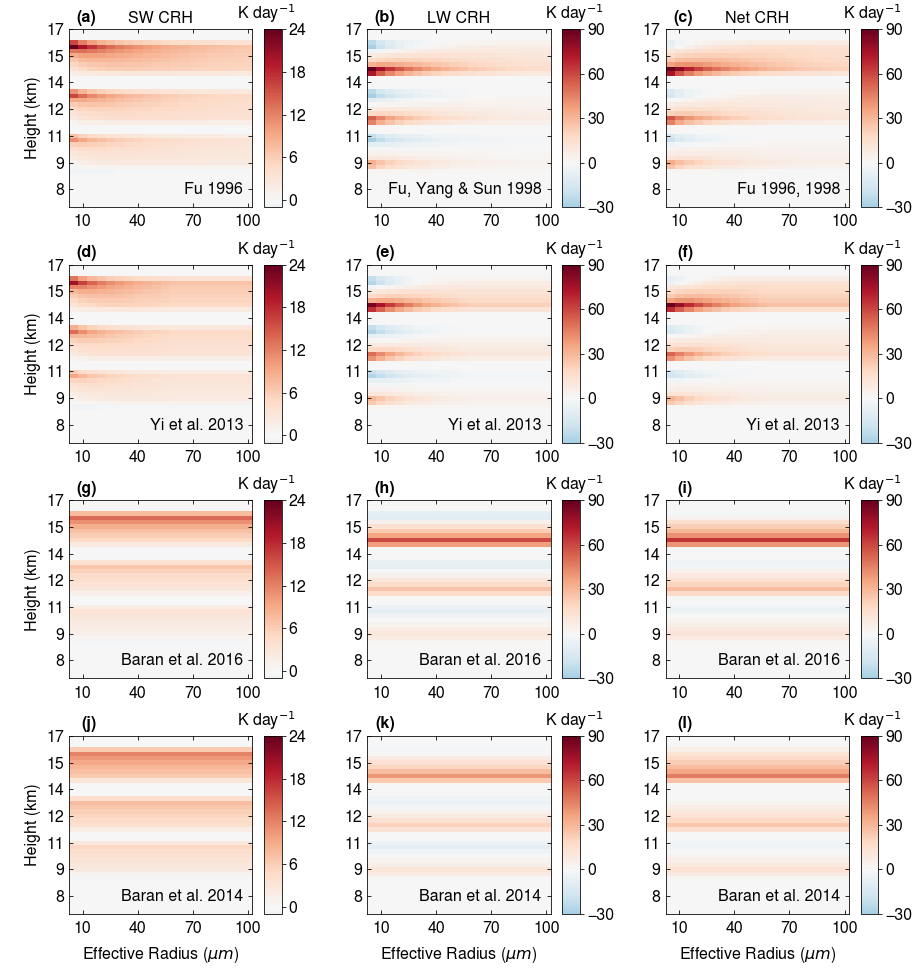

In [14]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 13.5 # inches
flength  = 12.75 # inches

rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.97, bottom = 0.06, left = 0.075, right = 0.975, 
                    hspace = .325, wspace = .3)

# COLORMAPS
vmini = -30
vmaxi = 90
tickbar = [vmini, 0, 30, 60, vmaxi]

#For shortwave:
vmini_sw = -1
vmaxi_sw = 24
tickbar_sw = [0, 6, 12, 18, vmaxi_sw]

for opt in range(rows): # Fu, Yi, Baran2016 and Baran 2014
    # Shortwave Heating Rate
    im = ax[opt, 0].imshow(H_sw_plot[opt, :, 1:], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 0].set_title('SW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[opt, 1].imshow(H_lw_plot[opt, :, 1:], cmap = 'RdBu_r', aspect = 'auto', 
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 1].set_title('LW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[opt, 2].imshow(H_plot[opt, :, 1:], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 2].set_title('Net CRH', color ='black',
                             fontsize = fontsize, fontname = fontname)

# AXIS PARAMETERS
# Y Axis
#yticks      = np.arange(0, H.shape[2]+1, 6) # altitude tick labels
yticks      = np.arange(0, H_236.shape[2]+1, 6) # altitude tick labels
#yticklabels = height_hl_pd.loc[yticks].round(1).to_list()
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
#yticklabels = temp.loc[yticks].astype('int').to_list()  

    
# X Axis:
#xticks      = np.arange(0, 24, 6)
#xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

re     = np.arange(5, 105, 5)
xticks = np.arange(1, len(re), int(len(re)/3))
#xticks      = xticks

xticklabels = re[xticks].round(0).astype('int')
#xticklabels = iwp[np.append(0, xticks[1:])]
#xticklabels_int = [0.1]
#for i in xticklabels[1:]:
#    xticklabels_int.append(int(i))
    
OptSch_sw       = ['Fu 1996', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch_lw       = ['Fu, Yang & Sun 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch          = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows): # Fu, Yi, Baran2016 and Baran 2014
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if opt == 3:
            ax[opt, j].set_xlabel(r'Effective Radius ($\mu m$)', 
                                  fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 7.5)
        ax[opt, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[opt, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_xticks(xticks)
        ax[opt, j].set_xticklabels(xticklabels) #[::-1]
        ax[opt, j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[opt, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_yticks(yticks)
        ax[opt, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
            ax[opt, j].text(0.95, 0.05, OptSch_sw[opt],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[opt, j].text(0.95, 0.05, OptSch_lw[opt],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[opt, j].text(0.95, 0.05, OptSch[opt],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        ax[opt, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[opt, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_re_1S_absolute_v6_SM.png', dpi=500)

Numer limits within range:

In [15]:
print('LW Fu max: ', H_lw_plot[0,:,2:13].max())
print('LW Fu min: ', H_lw_plot[0,:,2:13].min())
print('LW Yi max: ', H_lw_plot[1,:,2:13].max())
print('LW Yi min: ', H_lw_plot[1,:,2:13].min())
print('')
print('SW Fu max: ', H_sw_plot[0,:,2:13].max())
print('SW Fu min: ', H_sw_plot[0,:,2:13].min())
print('SW Yi max: ', H_sw_plot[1,:,2:13].max())
print('SW Yi min: ', H_sw_plot[1,:,2:13].min())
print('')
print('Fu max: ', H_plot[0,:,2:13].max())
print('Fu min: ', H_plot[0,:,2:13].min())
print('Yi max: ', H_plot[1,:,2:13].max())
print('Yi min: ', H_plot[1,:,2:13].min())

LW Fu max:  75.5296671300205
LW Fu min:  -22.22833517197425
LW Yi max:  74.06381558319572
LW Yi min:  -21.909186052070055

SW Fu max:  19.873342648738376
SW Fu min:  -0.7992712432349776
SW Yi max:  16.47526681417574
SW Yi min:  -0.7236551504952017

Fu max:  80.1934783191019
Fu min:  -12.982568379133012
Yi max:  78.38284548740316
Yi min:  -14.128121432284999


<IPython.core.display.Javascript object>


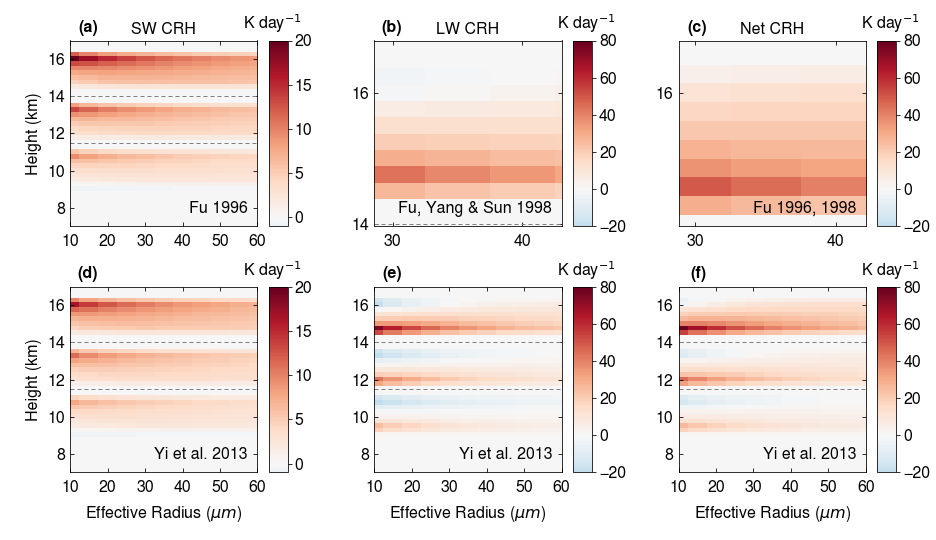

In [16]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 7.5 # inches
flength  = 13 # inches

rows    = 2
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.125, left = 0.075, right = 0.975, 
                    hspace = .325, wspace = .3)

# COLORMAPS
vmini   = -20
vmaxi   = 80
tickbar = [vmini, 0, 20, 40, 60, vmaxi]

#For shortwave:
vmini_sw   = -1
vmaxi_sw   = 20
tickbar_sw = [0, 5, 10, 15, vmaxi_sw]

for opt in range(rows): # Fu, Yi, Baran2016 and Baran 2014
    # Shortwave Heating Rate
    im = ax[opt, 0].imshow(H_sw_plot[opt, :, 1:], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 0].set_title('SW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[opt, 1].imshow(H_lw_plot[opt, :, 1:], cmap = 'RdBu_r', aspect = 'auto', 
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 1].set_title('LW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[opt, 2].imshow(H_plot[opt, :, 1:], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 2].set_title('Net CRH', color ='black',
                             fontsize = fontsize, fontname = fontname)
        
    ax[opt, 0].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[opt, 0].axhline((height_hl_pd - 14).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[opt, 1].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[opt, 1].axhline((height_hl_pd - 14).abs().argmin(), 
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[opt, 2].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[opt, 2].axhline((height_hl_pd - 14).abs().argmin(), 
                       dashes=[4, 3], color = 'grey', linewidth = 1)
   
# AXIS PARAMETERS
# Y Axis
#yticks      = np.arange(0, H.shape[2]+1, 6) # altitude tick labels
yticks      = np.arange(0, H_236.shape[2]+1, 8) # altitude tick labels
#yticklabels = height_hl_pd.loc[yticks].round(1).to_list()
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
#yticklabels = temp.loc[yticks].astype('int').to_list()  

    
# X Axis:
#xticks      = np.arange(0, 24, 6)
#xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

re     = np.arange(5, 105, 5)
xticks = np.arange(1, len(re), int(len(re)/10))
#xticks      = xticks

xticklabels = re[xticks].round(0).astype('int')
#xticklabels = iwp[np.append(0, xticks[1:])]
#xticklabels_int = [0.1]
#for i in xticklabels[1:]:
#    xticklabels_int.append(int(i))
    
OptSch_sw       = ['Fu 1996', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch_lw       = ['Fu, Yang & Sun 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch          = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows): # Fu, Yi, Baran2016 and Baran 2014
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if opt == 1:
            ax[opt, j].set_xlabel(r'Effective Radius ($\mu m$)', 
                                  fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 7.5)
        ax[opt, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[opt, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_xticks(xticks)
        ax[opt, j].set_xticklabels(xticklabels) #[::-1]
        ax[opt, j].set_xlim(1, 11) 
        ax[opt, j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[opt, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_yticks(yticks)
        ax[opt, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
            ax[opt, j].text(0.95, 0.05, OptSch_sw[opt],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[opt, j].text(0.95, 0.05, OptSch_lw[opt],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[opt, j].text(0.95, 0.05, OptSch[opt],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        ax[opt, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[opt, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_re_1S_absolute_v6b.png', dpi=500)

#### Plotting Differences Matrix

In [17]:
# Shortwave:
H_sw_diff_plot    = np.zeros((3, prof, rows_re))
H_sw_diff_plot[0] = H_sw_plot[1] - H_sw_plot[0] # Yi - Fu
H_sw_diff_plot[1] = H_sw_plot[2] - H_sw_plot[0] # Baran2016 - Fu
H_sw_diff_plot[2] = H_sw_plot[3] - H_sw_plot[0] # Baran2014 - Fu

# Longwave:
H_lw_diff_plot    = np.zeros((3, prof, rows_re))
H_lw_diff_plot[0] = H_lw_plot[1] - H_lw_plot[0] # Yi - Fu
H_lw_diff_plot[1] = H_lw_plot[2] - H_lw_plot[0] # Baran2016 - Fu
H_lw_diff_plot[2] = H_lw_plot[3] - H_lw_plot[0] # Baran2014 - Fu

# Net:
H_diff_plot    = np.zeros((3, prof, rows_re))
H_diff_plot[0] = H_plot[1] - H_plot[0] # Yi - Fu
H_diff_plot[1] = H_plot[2] - H_plot[0] # Baran - Fu
H_diff_plot[2] = H_plot[3] - H_plot[0] # Baran - Fu

In [18]:
# Shortwave CRH differences:
print('Shortwave CRH Differences:')
print('Yi - Fu max: ',H_sw_diff_plot[0,:,2:13].max())
print('Yi - Fu min: ',H_sw_diff_plot[0,:,2:13].min())

print('')
# Longwave CRH differences:
print('Longwave CRH Differences:')
print('Yi - Fu max: ',H_lw_diff_plot[0,:,2:13].max())
print('Yi - Fu min: ',H_lw_diff_plot[0,:,2:13].min())

print('')
# Net CRH differences:
print('Net CRH Differences:')
print('Yi - Fu max: ',H_diff_plot[0,:,2:13].max())
print('Yi - Fu min: ',H_diff_plot[0,:,2:13].min())

Shortwave CRH Differences:
Yi - Fu max:  0.09253291873280872
Yi - Fu min:  -3.3980758345626363

Longwave CRH Differences:
Yi - Fu max:  1.4894992746837898
Yi - Fu min:  -3.4925222642901943

Net CRH Differences:
Yi - Fu max:  0.11907690420462025
Yi - Fu min:  -4.1129514470326285


<IPython.core.display.Javascript object>


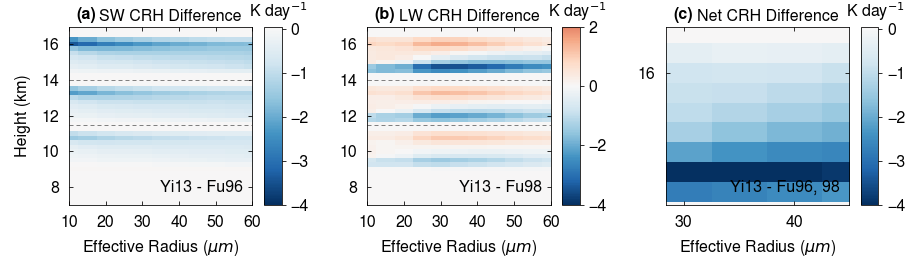

In [19]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
flength  = 12.75 # inches
fheigth  = flength*0.29 # inches

rows    = 1
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.23, left = 0.075, right = 0.975, 
                    hspace = .3, wspace = .3)

# COLORMAPS
for diff in range(rows): # Yi - Fu
    if diff == 0: # Yi - Fu
        vmini_sw   = -4; vmaxi_sw = .05
        tickbar_sw = [vmini_sw, -3, -2, -1, 0]
        vmini_lw   = -4; vmaxi_lw = 2
        tickbar_lw = [vmini_lw, -2, 0, vmaxi_lw]
        labelpad   = -30
    
    # Shortwave Heating Rate Difference
    im = ax[0].imshow(H_sw_diff_plot[diff, :, 1:], cmap = "RdBu_r", aspect = 'auto',
                            norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[0].set_title('SW CRH Difference', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[1].imshow(H_lw_diff_plot[diff, :, 1:], cmap = "RdBu_r", aspect = 'auto', 
                            norm = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[1].set_title('LW CRH Difference', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[2].imshow(H_diff_plot[diff, :, 1:], cmap = "RdBu_r", aspect = 'auto',
                            norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[2].set_title('Net CRH Difference', color ='black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
    ax[0].axhline((height_hl_pd - 11.5).abs().argmin(),
                  dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[0].axhline((height_hl_pd - 14).abs().argmin(),
                  dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[1].axhline((height_hl_pd - 11.5).abs().argmin(),
                  dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[1].axhline((height_hl_pd - 14).abs().argmin(), 
                  dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[2].axhline((height_hl_pd - 11.5).abs().argmin(),
                  dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[2].axhline((height_hl_pd - 14).abs().argmin(), 
                  dashes=[4, 3], color = 'grey', linewidth = 1)

        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H_236.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
re     = np.arange(5, 105, 5)
xticks = np.arange(1, len(re), int(len(re)/10))
xticklabels = re[xticks].round(0).astype('int')

Diff_sw         = ['Yi13 - Fu96', 'Baran16 - Fu96', 'Baran14 - Fu96']
Diff_lw         = ['Yi13 - Fu98', 'Baran16 - Fu98', 'Baran14 - Fu98']
Diff            = ['Yi13 - Fu96, 98', 'Baran16 - Fu96, 98', 'Baran14 - Fu96, 98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for diff in range(rows): # Yi - Fu, Baran2016 - Fu and Baran2014 - Fu
    for j in range(columns):
        if diff == 0:
            ax[j].set_xlabel(r'Effective Radius ($\mu m$)', 
                             fontsize = fontsize, fontname = fontname,
                             color ='black', labelpad = 7.5)
        ax[j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[j].get_xticklabels():
            tick.set_fontname(fontname)
        
        # Log scale:
        #ax[opt, j].set_xscale('log')
        #ax[opt, j].set_xlim(-10, 2000) # In terms of bin (From position 1 (0.2 gm^2) to position 2000 (200.1 gm^2))
        ax[j].set_xticks(xticks)
        ax[j].set_xticklabels(xticklabels) #[::-1]
        #ax[diff, j].set_xlim(0, 2000) # In terms of bin (From position 1 (0.2 gm^2) to position 2000 (200.1 gm^2))
        ax[j].set_xlim(1, 11)
        
        ax[j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[j].set_yticks(yticks)
        ax[j].set_yticklabels(yticklabels)
        if j == 0:
            ax[j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[j].text(0.95, 0.05, Diff_sw[diff],
                             ha = 'right', va = 'bottom', transform = ax[j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[j].text(0.95, 0.05, Diff_lw[diff],
                             ha = 'right', va = 'bottom', transform = ax[j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[j].text(0.95, 0.05, Diff[diff],
                             ha = 'right', va = 'bottom', transform = ax[j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_re_diff_1S_v6d.png', dpi=500)